# Qiskit Algorithms Migration Guide

**Restructuring the applications**

The Qiskit 0.25.0 release includes a restructuring of the applications and algorithms. What previously has been referred to as Qiskit Aqua, the single applications and algorithms module of Qiskit, is now split into dedicated application modules for Optimization, Finance, Machine Learning and Nature (including Physics & Chemistry). The core algorithms and opflow operator functionality are moved to Qiskit Terra.

**Algorithm interfaces**

Additionally to the restructuring, all algorithms follow a new unified paradigm: algorithms are classified according to the problems they solve, and within one application class algorithms can be used interchangeably to solve the same problem. This means that, unlike before, algorithm instances are decoupled from the problem they solve. We can summarize this in a flowchart:

<img src="algorithmflow.png" alt="Drawing" style="width: 1000px;"/>

For example, the variational quantum eigensolver, `VQE` is a `MinimumEigensolver` as it computes the minimum eigenvalue of an operator. The problem here is specified with the operator, whose eigenvalue we seek, while properties such as the variational ansatz circuit and classical optimizer are properties of the algorithm. That means the `VQE` has the following structure
```python
vqe = VQE(ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(operator)
```
We can exchange the `VQE` with any other algorithm that implements the `MinimumEigensolver` interface to compute the eigenvalues of your operator, e.g.
```
numpy_based = NumPyMinimumEigensolver()
classical_reference = numpy_based.compute_minimum_eigenvalue(operator)
```
This allows you to easily switch between different algorithms, check against classical references, and provide your own implementation $-$ you just have to implement the existing interface.

This notebook serves as migration guide to facilitate changing your current code using Qiskit Aqua to the new structure.


We're disabling deprecation warning for this notebook so you won't see any when we instantiate an object from `qiskit.aqua`. Note though, that the entire package is deprecated and will emit a warning like the following:

In [1]:
from qiskit.aqua.components.optimizers import COBYLA

optimizer = COBYLA()

/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/manoel/projects/Quantum/qiskit-aqua/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


In [2]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

# QuantumInstance

The `QuantumInstance` moved the import location from
```
qiskit.aqua.QuantumInstance
```
to 
```
qiskit.utils.QuantumInstance
```

**Previously:**

In [3]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance as AquaQuantumInstance

backend = Aer.get_backend('statevector_simulator')
aqua_qinstance = AquaQuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

**New:**

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

# Operators

The Opflow operators moved from
```
qiskit.aqua.operators
```
to
```
qiskit.opflow
```

**Previously:**

In [5]:
from qiskit.aqua.operators import X, I, Y

op = (X ^ I) + (Y ^ 2)

**New:**

In [6]:
from qiskit.opflow import X, I, Y

op = (X ^ I) + (Y ^ 2)

**Additional features:**

With `qiskit.opflow` we introduce a new, more efficient representation of sums of Pauli strings, which can significantly speed up computations on very large sums of Paulis. This efficient representation is automatically used if Pauli strings are summed:

In [7]:
op = (X ^ X ^ Y ^ Y) + (X ^ 4) + (Y ^ 4) + (I ^ X ^ I ^ I)
type(op)

qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp

# Optimizers

The classical optimization routines changed locations from
```
qiskit.aqua.components.optimizers
```
to 
```
qiskit.algorithms.optimizers
```

**Previously:**

In [8]:
from qiskit.aqua.components.optimizers import SPSA

spsa = SPSA(maxiter=10)

**New:**

In [9]:
from qiskit.algorithms.optimizers import SPSA

spsa = SPSA(maxiter=10)

# Grover

## Summary

The previous structure
```python
grover = Grover(oracle_settings, algorithm_settings)
result = grover.run()
```
is changed to split problem/oracle settings and algorithm settings, to
```python
grover = Grover(algorithm_settings)
problem = AmplificationProblem(oracle_settings)
result = grover.amplify(problem)
```
<!-- See the documentation of the [deprecated Grover](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Grover.html#qiskit.aqua.algorithms.Grover) and [new Grover](#). -->

## Migration guide

For oracles provided as circuits and a `is_good_state` function to determine good states

In [10]:
from qiskit.circuit import QuantumCircuit

oracle = QuantumCircuit(2)
oracle.cz(0, 1)

def is_good_state(bitstr):
    return sum(map(int, bitstr)) == 2

**Previously:**

In [11]:
from qiskit.aqua.algorithms import Grover

grover = Grover(oracle, is_good_state, quantum_instance=aqua_qinstance)
result = grover.run()
print('Top measurement:', result.top_measurement)

Top measurement: 11


**New:**

In [12]:
from qiskit.algorithms import Grover, AmplificationProblem

problem = AmplificationProblem(oracle=oracle, is_good_state=is_good_state)
grover = Grover(quantum_instance=qinstance)
result = grover.amplify(problem)
print('Top measurement:', result.top_measurement)

Top measurement: 11


Since we are streamlining all algorithms to use the `QuantumCircuit` class as base primitive, defining oracles using the `qiskit.aqua.compontents.Oracle` class is deprecated. Instead of using e.g. the `LogicalExpressionOracle` you can now use the `PhaseOracle` circuit from the circuit library.

**Previously:**

In [13]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit.aqua.algorithms import Grover

oracle = LogicalExpressionOracle('x & ~y')
grover = Grover(oracle, quantum_instance=aqua_qinstance)
result = grover.run()
print('Top measurement:', result.top_measurement)

Top measurement: 01


**New:**

In [14]:
from qiskit.circuit.library import PhaseOracle
from qiskit.algorithms import Grover, AmplificationProblem

oracle = PhaseOracle('x & ~y')
problem = AmplificationProblem(oracle=oracle, is_good_state=oracle.evaluate_bitstring)
grover = Grover(quantum_instance=qinstance)
result = grover.amplify(problem)
print('Top measurement:', result.top_measurement)

Top measurement: 01


The `qiskit.aqua.components.oracles.TruthTableOracle` is not yet ported, but the behaviour can easily be achieved with the `qiskit.circuit.classicalfunction` module, see the tutorials on Grover's algorithm.

## More examples

To construct the circuit we can call `construct_circuit` and pass the problem instance we are interested in:

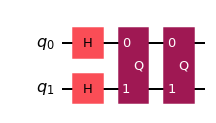

In [15]:
power = 2
grover.construct_circuit(problem, power).draw('mpl', style='iqx')

# Amplitude estimation

## Summary

For all amplitude estimation algorithms 
* `AmplitudeEstimation`
* `IterativeAmplitudeEstimation`
* `MaximumLikelihoodAmplitudeEstimation`, and
* `FasterAmplitudeEstimation`

the interface changed from
```python
qae = AmplitudeEstimation(algorithm_settings, estimation_settings)
result = qae.run()
```
to split problem/oracle settings and algorithm settings
```python
qae = AmplitudeEstimation(algorithm_settings)
problem = EstimationProblem(oracle_settings)
result = qae.amplify(problem)
```
<!-- See the documentation of the [deprecated amplitude estimation algorithms](https://qiskit.org/documentation/apidoc/qiskit.aqua.algorithms.html#amplitude-estimators) and [new ones](#). -->

## Migration guide

Here, we'd like to estimate the probability of measuring a $|1\rangle$ in our single qubit. If the state preparation is provided as circuit

Target probability: 0.25


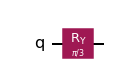

In [16]:
import numpy as np

probability = 0.25
rotation_angle = 2 * np.arcsin(np.sqrt(probability))

state_preparation = QuantumCircuit(1)
state_preparation.ry(rotation_angle, 0)

objective_qubits = [0]  # the good states are identified by qubit 0 being in state |1>

print('Target probability:', probability)

state_preparation.draw(output='mpl', style='iqx')

**Previously:**

In [17]:
from qiskit.aqua.algorithms import AmplitudeEstimation

# instantiate the algorithm and passing the problem instance
ae = AmplitudeEstimation(3, state_preparation, quantum_instance=aqua_qinstance)

# run the algorithm
result = ae.run()

# print the results
print('Grid-based estimate:', result.estimation) 
print('Improved continuous estimate:', result.mle)

Grid-based estimate: 0.1464466
Improved continuous estimate: 0.2499999956526605


**Now:**

In [18]:
from qiskit.algorithms import AmplitudeEstimation, EstimationProblem

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=objective_qubits)
ae = AmplitudeEstimation(num_eval_qubits=3, quantum_instance=qinstance)

result = ae.estimate(problem)
print('Grid-based estimate:', result.estimation) 
print('Improved continuous estimate:', result.mle)

Grid-based estimate: 0.1464466
Improved continuous estimate: 0.2499999956513743


Note that the old class used the last qubit in the `state_preparation` as objective qubit as default, if no other indices were specified. This default does not exist anymore to improve transparency and remove implicit assumptions.

## More examples

To construct the circuit for amplitude estimation, we can do

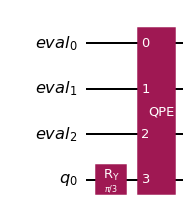

In [19]:
ae.construct_circuit(estimation_problem=problem).draw('mpl', style='iqx')

Now that the problem is separated from the algorithm we can exchange `AmplitudeEstimation` with any other algorithm that implements the `AmplitudeEstimator` interface.

In [20]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(epsilon_target=0.01, alpha=0.05, quantum_instance=qinstance)

result = iae.estimate(problem)
print('Estimate:', result.estimation)

Estimate: 0.24999999999999994


In [21]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(evaluation_schedule=[0, 2, 4], quantum_instance=qinstance)

result = mlae.estimate(problem)
print('Estimate:', result.estimation)

Estimate: 0.2500081904035319


# Minimum eigenvalues

## Summary

* The interface remained mostly the same, but where previously it was possible to pass the operator in the initializer .
* The operators must now be constructed with operators from `qiskit.opflow` instead of `qiskit.aqua.operators`.
* The `VQE` argument `var_form` has been renamend to `ansatz`.

## Migration guide

Assume we want to find the minimum eigenvalue of 
$$
H = Z \otimes I.
$$

### NumPy-based eigensolver

**Previously:**

Previously we imported the operators from `qiskit.aqua.operators`:

In [22]:
from qiskit.aqua.operators import Z, I

observable = Z ^ I

and then solved for the minimum eigenvalue using

In [23]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

mes = NumPyMinimumEigensolver()
result = mes.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-1+0j)


It used to be possible to pass the observable in the initializer, which is now not allowed anymore due to the problem-algorithm separation.

In [24]:
mes = NumPyMinimumEigensolver(observable)
result = mes.compute_minimum_eigenvalue()
print(result.eigenvalue)

(-1+0j)


**Now:**

Now we need to import from `qiskit.opflow` but the other syntax remains exactly the same:

In [25]:
from qiskit.opflow import Z, I

observable = Z ^ I 

In [26]:
from qiskit.algorithms import NumPyMinimumEigensolver

mes = NumPyMinimumEigensolver()

result = mes.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-1+0j)


### VQE

The same changes hold for VQE. Let's use the `RealAmplitudes` circuit as ansatz:

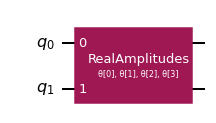

In [27]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(2, reps=1)
ansatz.draw(output='mpl', style='iqx')

**Previously:**

Previously, we had to import both the optimizer and operators from Qiskit Aqua:

In [28]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.operators import Z, I

observable = Z ^ I

vqe = VQE(var_form=ansatz, optimizer=COBYLA(), quantum_instance=aqua_qinstance)
result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999999971946394+0j)


**Now:** 

Now we import optimizers from `qiskit.algorithms.optimizers` and operators from `qiskit.opflow`.

In [29]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import Z, I

observable = Z ^ I

vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
result = vqe.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999995645308767+0j)


Note that the `qiskit.aqua.components.variational_forms` are completely deprecated in favor of circuit objects. Most variational forms have already been ported to circuit library in previous releases and now also `UCCSD` is part of the Qiskit Nature's circuit library:

**Previously:**

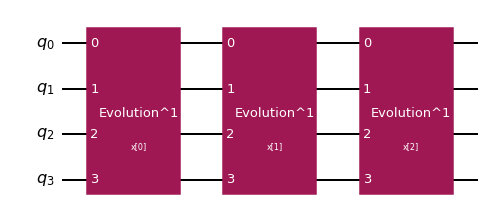

In [30]:
from qiskit.circuit import ParameterVector
from qiskit.chemistry.components.variational_forms import UCCSD

varform = UCCSD(4, (1, 1), qubit_mapping='jordan_wigner', two_qubit_reduction=False)
parameters = ParameterVector('x', varform.num_parameters)

circuit = varform.construct_circuit(parameters)
circuit.draw('mpl', style='iqx')

**New:**

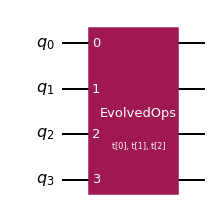

In [31]:
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import UCCSD

qubit_converter = QubitConverter(JordanWignerMapper())

circuit = UCCSD(qubit_converter, (1, 1), 4)
circuit.draw('mpl', style='iqx')

### QAOA

For Hamiltonians from combinatorial optimization (like ours: $Z \otimes I$) we can use the QAOA algorithm.

**Previously:**

In [32]:
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.operators import Z, I

observable = Z ^ I

qaoa = QAOA(optimizer=COBYLA(), quantum_instance=aqua_qinstance)
result = qaoa.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999999808672868+0j)


**Now:**

In [33]:
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import Z, I

observable = Z ^ I

qaoa = QAOA(optimizer=COBYLA(), quantum_instance=qinstance)
result = qaoa.compute_minimum_eigenvalue(observable)
print(result.eigenvalue)

(-0.9999999752264653+0j)


**More examples:**

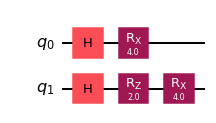

In [34]:
qaoa.construct_circuit([1, 2], observable)[0].draw(output='mpl', style='iqx')

### Classical CPLEX

The `ClassicalCPLEX` algorithm is now available via the `CplexOptimizer` interface in the machine learning module.

**Previously:**

In [35]:
from qiskit.aqua.algorithms import ClassicalCPLEX
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.quantum_info import Pauli

op = WeightedPauliOperator([
    [1, Pauli('ZZIII')],
    [1, Pauli('ZIIIZ')],
    [1, Pauli('IZZII')]
])

cplex = ClassicalCPLEX(op, display=0)
result = cplex.run()
print('Energy:', result['energy'])

Version identifier: 20.1.0.0 | 2020-11-11 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_MIP_Display                             0
CPXPARAM_TimeLimit                               600
CPXPARAM_MIP_Tolerances_MIPGap                   0
CPXPARAM_MIP_Tolerances_Integrality              0
Energy: -3.0


**New:**

In [36]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit.opflow import I, Z

op = (Z ^ Z ^ I ^ I ^ I) + (Z ^ I ^ I ^ I ^ Z) + (I ^ Z ^ Z ^ I ^ I)

qp = QuadraticProgram()
qp.from_ising(op)

cplex = CplexOptimizer()
result = cplex.solve(qp)

print('Energy:', result.fval)

Energy: -3.0


# (General) Eigenvalues

## Summary

As for the `MinimumEigenSolver`, the only change for the `EigenSolver` is the type for the observable and the import path.

## Migration guide

**Previously:**

In [37]:
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.operators import I, Z

observable = Z ^ I

es = NumPyEigensolver(k=3)  # get the lowest 3 eigenvalues

result = es.compute_eigenvalues(observable)
print(result.eigenvalues)

[-1.+0.j -1.+0.j  1.+0.j]


**Now:**

In [38]:
from qiskit.algorithms import NumPyEigensolver
from qiskit.aqua.operators import I, Z

observable = Z ^ I

es = NumPyEigensolver(k=3)  # get the lowest 3 eigenvalues

result = es.compute_eigenvalues(observable)
print(result.eigenvalues)

[-1.+0.j -1.+0.j  1.+0.j]


# Shor's algorithm

## Summary

The arguments `N` and `a` moved from the initializer to the `Shor.factor` method.

## Migration guide

We'll be using a shot-based readout for speed here.

In [39]:
aqua_qasm_qinstance = AquaQuantumInstance(Aer.get_backend('qasm_simulator'))
qasm_qinstance = QuantumInstance(Aer.get_backend('qasm_simulator'))

**Previously:**

In [40]:
from qiskit.aqua.algorithms import Shor

shor = Shor(N=9, a=2, quantum_instance=aqua_qinstance)

result = shor.run()
print('Factors:', result['factors'])

Factors: [3]


**New:**

In [41]:
from qiskit.algorithms import Shor

shor = Shor(quantum_instance=qinstance)

result = shor.factor(N=9, a=2)
print('Factors:', result.factors)

Factors: [3]


# HHL

## Summary

HHL has been completely refactored to allow an intuitive interface and return an efficient, circuit-based representation of the result. 

## Migration guide

Assume we want to solve the following linear system
$$
\begin{pmatrix}
1 & -1/3 \\
-1/3 & 1 \\
\end{pmatrix}
\vec x
=
\begin{pmatrix}
1 \\ 0
\end{pmatrix}
$$

In [42]:
import numpy as np

matrix = np.array([[1, -1/3], [-1/3, 1]])
vector = np.array([1, 0])

**Previously:**

In [43]:
from qiskit.circuit.library import QFT
from qiskit.aqua.algorithms import HHL
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua.operators import MatrixOperator

def create_eigs(matrix, num_auxiliary, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_auxiliary += 1
        ne_qfts = [QFT(num_auxiliary - 1), QFT(num_auxiliary - 1).inverse()]
    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_auxiliary).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_auxiliary,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None, 
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

orig_size = len(vector)

matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)
algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)

result = algo.run(aqua_qinstance)
print(result.solution)

[ 0.66575607+4.96430258e-13j -0.38561455-2.84524449e-13j]


**Now:**

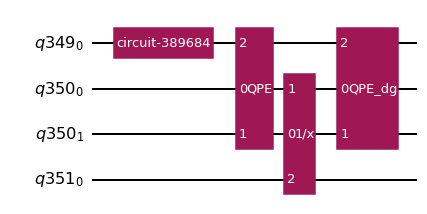

In [44]:
from qiskit.algorithms.linear_solvers import HHL

hhl = HHL()
result = hhl.solve(matrix, vector)
result.state.draw('mpl', style='iqx')

Note that the solution vector is not returned, since that would require an exponentially expensive simulation of the solution circuit. Instead, the circuit can be used to evaluate observables on the solution. For details, see the documentation and docstrings of HHL.

### NumPy-based linear solver

**Previously:**

In [45]:
from qiskit.aqua.algorithms import NumPyLSsolver

ls = NumPyLSsolver(matrix, vector)
result = ls.run()
print(result.solution)

[1.125, 0.37499999999999994]


**Now:**

In [46]:
from qiskit.algorithms import NumPyLinearSolver

ls = NumPyLinearSolver()
result = ls.solve(matrix, vector)
print(result.state)

[1.125 0.375]


# Phase estimation

## Summary

Phase estimation has been completely refactored and instead of just one `qiskit.aqua.algorithms.QPE` class that was used to compute the eigenvalue of a Hamiltonian, we now have two separate implementations: the `HamiltonianPhaseEstimation` taking the role of the old `QPE` and a new `PhaseEstimation` algorithm for textbook phase estimation.

The iterative phase estimation, `qiskit.aqua.algorithms.IQPE` is not yet replaced but will follow soon.

## Migration guide

Let's consider the problem of finding the eigenvalue of

$$
H = 0.5 X + Y + Z
$$
with the input state $|0\rangle$.

In [47]:
state_in = np.array([1, 0])

**Previously:**

In [48]:
from qiskit.circuit.library import QFT
from qiskit.aqua.algorithms import QPE
from qiskit.aqua.components.initial_states import Custom
from qiskit.aqua.operators import I, X, Y, Z

n_ancillae = 5
num_time_slices = 1

op = 0.5 * X + Y + Z

state_preparation = Custom(op.num_qubits, state_vector=state_in)
iqft = QFT(n_ancillae, do_swaps=False).inverse().reverse_bits()

qpe = QPE(op, state_preparation, iqft, num_time_slices, n_ancillae,
          expansion_mode='trotter', 
          shallow_circuit_concat=True)


result = qpe.run(aqua_qinstance)

print(result.eigenvalue)

0.78125


**New:**

In [49]:
from qiskit import BasicAer
from qiskit.algorithms import HamiltonianPhaseEstimation
from qiskit.opflow import I, X, Y, Z, StateFn, PauliTrotterEvolution, Suzuki

n_ancillae = 5
num_time_slices = 1

op = 0.5 * X + Y + Z

state_preparation = StateFn(state_in)

evolution = PauliTrotterEvolution('trotter', reps=num_time_slices)

qpe = HamiltonianPhaseEstimation(n_ancillae, quantum_instance=qinstance)
result = qpe.estimate(op, state_preparation, evolution=evolution)

print(result.most_likely_eigenvalue)

0.78125


## More examples

Now we can also do standard phase estimation to solve
$$
    U|\psi\rangle = e^{2\pi i\phi}|\psi\rangle.
$$

In [50]:
from qiskit.circuit import QuantumCircuit
from qiskit.algorithms import PhaseEstimation

unitary = QuantumCircuit(1)
unitary.z(0)

state_in = QuantumCircuit(1)
state_in.x(0)  # eigenstate |1> with eigenvalue -1, hence a phase of phi = 0.5

pe = PhaseEstimation(num_evaluation_qubits=3, quantum_instance=qinstance)
result = pe.estimate(unitary, state_in)

print(result.most_likely_phase)

0.5


# VQC

## Summary

`VQC` changed the location to `qiskit_machine_learning.algorithms.VQC` and is now implemented as `NeuralNetworkClassification` object instead of a generic variational algorithm. The interface has been updated accordingly, see the tutorials below.

## Migration guide

Since the examples are rather lengthy, we refer to a comparison of the previous and new tutorials.

**Previously:** 

https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/machine_learning/03_vqc.ipynb

**New:**

https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/02_neural_network_classifier_and_regressor.ipynb


# QSVM

## Summary

The `QSVM` workflow has been replaced by a more generic `QuantumKernel` routine to better highlight the possibly advantage of quantum computers in computing kernels. 

## Migration guide

**Previously:**

https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/machine_learning/01_qsvm_classification.ipynb

**New:**

https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/03_quantum_kernel.ipynb

# QGAN

## Summary

The interface and methods remained the same, only the import location of the algorithm and it's components changed from `qiskit.aqua` to `qiskit_machine_learning`.

## Migration guide

**Previously:**

https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/machine_learning/04_qgans_for_loading_random_distributions.ipynb

**New:**

https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/04_qgans_for_loading_random_distributions.ipynb

# Educational algorithms

All educational algorithms have been deprecated and most are now available in the textbook.

## Deutsch-Josza

Moved to the textbook: https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html.

## Bernstein-Vazirani

Moved to the textbook: https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html.

## Simon

Moved to the textbook: https://qiskit.org/textbook/ch-algorithms/simon.html.

## EOH

The Evolution of Hamiltonian algorithm is can now be implemented with basic tools from `qiskit.opflow`.

**Previously:**

In [51]:
from qiskit.aqua.algorithms import EOH
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.quantum_info import Pauli

hamiltonian = WeightedPauliOperator([[1, Pauli('XX')], [1, Pauli('ZZ')], [1j, Pauli('YY')]])

observable = WeightedPauliOperator([[1, Pauli('XI')]])

initial_state = Custom(2, 'uniform')

evo_time = 2
num_time_slices = 10

eoh = EOH(observable, initial_state, hamiltonian, evo_time=evo_time, num_time_slices=num_time_slices)
result = eoh.run(aqua_qinstance)
result['avg']

(-0.6536436208636113+0j)

**New:**

In [52]:
import numpy as np
from qiskit.opflow import I, X, Y, Z, PauliTrotterEvolution, StateFn

hamiltonian = (X ^ X) + (Z ^ Z) + 1j * (Y ^ Y)

observable = X ^ I

initial_state = StateFn(np.ones(4) / 2)

evo_time = 2
num_time_slices = 10

# get the evolution operator
evolved_hamiltonian = (evo_time * hamiltonian).exp_i()

evo = PauliTrotterEvolution(reps=num_time_slices)
evo.convert(evolved_hamiltonian)

# get the evolved state
evolved_state = evolved_hamiltonian @ initial_state

# evaluate the target observable at the evolved state
print((~StateFn(observable) @ evolved_state).eval())

(-0.6536436208636165+0j)
